<h1 style="color:#7b1e1e; text-align:center; font-family: Arial, sans-serif;">
    Projet personnel de scoring de crédit 
</h1>
<p style="text-align:center; font-style: italic; color:#5a5a5a;">
    Analyse du risque de défaut et création d'un modèle prédictif à partir du jeu de données credit_risk_dataset sur Kaggle.
</p>

---

<h2 style="color:#8c2f2f;">
    Introduction
</h2>

Dans le secteur financier, évaluer avec précision le risque de défaut est primordial pour la rentabilité et la stabilité des établissements de crédit. Ce projet vise à développer un modèle de scoring performant en utilisant des techniques de Machine Learning. À partir d'un jeu de données (https://www.kaggle.com/datasets/laotse/credit-risk-dataset) contenant des informations personnelles et financières sur des emprunteurs lambda, nous allons explorer les données, préparer les variables pertinentes, puis entraîner et comparer plusieurs modèles de classification (régression logistique, forêt aléatoire et XGBoost). L'objectif final est de sélectionner le modèle le plus apte à prédire si un nouveau client est susceptible de faire défaut sur son prêt, afin de fournir un outil d'aide à la décision fiable et automatisé.

Ce notebook est structuré comme suit :
<ol>
    <li><strong>Préparation et exploration des données :</strong> Importation, nettoyage (doublons, valeurs manquantes, valeurs aberrantes) et première analyse descriptive.</li>
    <li><strong>Analyse exploratoire :</strong> Visualisations pour comprendre les relations entre les variables et identifier les features les plus pertinentes.</li>
    <li><strong>Modélisation et évaluation :</strong> Préparation des données pour l'entraînement, optimisation et comparaison de trois modèles (régression logistique, forêt aléatoire, XGBoost).</li>
    <li><strong>Conclusion et perspectives :</strong> Synthèse des résultats et discussion des prochaines étapes possibles.</li>
</ol>

<h2 style="color:#8c2f2f;">
    I- Préparation et exploration des données
</h2>

<h3 style="color:#9e3b3b;">
    A. Import des librairies et du jeu de données
</h3>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline 
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    f1_score,
    accuracy_score,
)

In [2]:
# Configuration
DATA_PATH = "../data/credit_risk_dataset.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 3

In [3]:
credit = pd.read_csv(DATA_PATH)

<h3 style="color:#9e3b3b;">
    B. Exploration des données
</h3>

In [4]:
credit.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


- **person_age** : Âge de l’individu qui fait la demande de prêt.  
- **person_income** : Revenu annuel de l’individu.  
- **person_home_ownership** : Type de propriété du logement de l’individu.  
  - **rent** : L’individu loue actuellement un logement.  
  - **mortgage** : L’individu a une hypothèque sur le logement qu’il possède.  
  - **own** : L’individu possède son logement sans crédit.  
  - **other** : Autres catégories de propriété du logement pouvant être spécifiques au jeu de données.  
- **person_emp_length** : Ancienneté professionnelle de l’individu en années.  
- **loan_intent** : Motif de la demande de prêt.  
- **loan_grade** : La note attribuée au prêt en fonction de la solvabilité de l’emprunteur.  
  - **A** : L’emprunteur a une grande solvabilité, indiquant un faible risque.  
  - **B** : L’emprunteur présente un risque relativement faible, mais inférieur à la note A.  
  - **C** : La solvabilité de l’emprunteur est moyenne.  
  - **D** : L’emprunteur est considéré comme présentant un risque plus élevé que les notes précédentes.  
  - **E** : La solvabilité de l’emprunteur est faible, indiquant un risque élevé.  
  - **F** : L’emprunteur présente un risque de crédit significatif.  
  - **G** : La solvabilité de l’emprunteur est la plus faible, signifiant le risque le plus élevé.  
- **loan_amnt** : Montant du prêt demandé par l’individu.  
- **loan_int_rate** : Taux d’intérêt associé au prêt.  
- **loan_status** : Statut du prêt, où 0 indique aucun défaut de paiement et 1 indique un défaut.  
  - **0** : Aucun défaut – L’emprunteur a remboursé le prêt comme convenu, sans défaut.  
  - **1** : Défaut – L’emprunteur n’a pas respecté les conditions de remboursement et a fait défaut sur le prêt.  
- **loan_percent_income** : Pourcentage du revenu représenté par le montant du prêt.  
- **cb_person_default_on_file** : Antécédent de défaut de paiement de l’individu selon les registres du bureau de crédit.  
  - **Y** : L’individu a des antécédents de défauts de paiement.  
  - **N** : L’individu n’a aucun antécédent de défaut de paiement.  
- **cb_preson_cred_hist_length** : Durée de l’historique de crédit de l’individu.

In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


<h3 style="color:#9e3b3b;">
    C. Nettoyage et prétraitement
</h3>

#### - Statistiques descriptives des variables numériques

In [6]:
credit.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


#### - Statistiques descriptives des variables qualitatives

In [7]:
credit.describe(include='O')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


<h4 style="color:#b55e5e;">
    1. Vérification des doublons
</h4>

In [8]:
credit.duplicated().sum()

165

In [9]:
credit = credit.drop_duplicates() 

<h4 style="color:#b55e5e;">
    2. Gestion des valeurs manquantes
</h4>

In [10]:
credit.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [11]:
credit[['person_emp_length', 'loan_int_rate']].isnull().mean() * 100 # Pourcentage de valeurs manquantes
# dans les colonnes person_emp_length et loan_int_rate

person_emp_length    2.736303
loan_int_rate        9.547754
dtype: float64

Nous avons des valeurs manquantes pour les variables `person_emp_length` et `loan_int_rate`. Nous allons pour chacune d'elles étudier leur distribution pour pouvoir décider de ce que nous allons en faire.

#### - Pour la variable person_emp_length

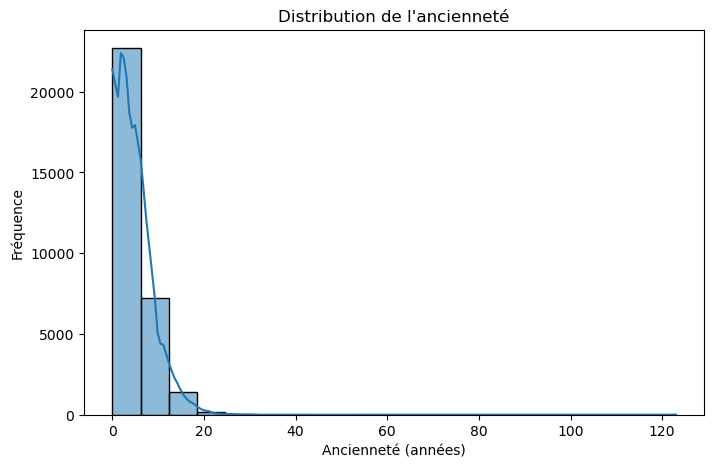

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(credit['person_emp_length'], bins=20, kde=True)  
plt.title("Distribution de l'ancienneté")
plt.xlabel("Ancienneté (années)")
plt.ylabel("Fréquence")
plt.show()

La distribution de l'ancienneté est asymétrique. La grande majorité des individus a peu d'années d'expérience, et une minorité seulement a une longue carrière (plus de 30 ans). Ainsi, nous préférons remplacer les valeurs manquantes de cette variable par la médiane plutôt que par la moyenne. En effet, les valeurs élevées peuvent tirer la moyenne vers le haut, la rendant moins représentative du centre de la distribution. La médiane, elle, n'est pas affectée par ces valeurs extrêmes. Elle représente donc mieux l'ancienneté "typique" d'une personne dans le jeu de données.

In [13]:
median_emp_length = credit['person_emp_length'].median()
credit.loc[:, 'person_emp_length'] = credit['person_emp_length'].fillna(median_emp_length) 

#### - Pour la variable loan_int_rate

La variable `loan_int_rate` a également près de 10% de valeurs manquantes. Une première idée serait de les imputer de manière intelligente. Par exemple, comme le taux d'intérêt est fortement corrélé à la note du prêt (`loan_grade`), on pourrait remplacer les valeurs manquantes par la médiane des taux pour chaque `loan_grade`. Le coefficient de corrélation de 0.93 entre ces deux variables confirme que cette approche serait plus précise qu'une simple médiane globale.
Cependant, cette démarche soulève une question fondamentale : les variables `loan_int_rate` et `loan_grade` sont-elles des informations disponibles avant la décision de crédit ? Très probablement non. Elles sont le résultat de cette évaluation.
Les utiliser pour prédire le défaut de paiement créerait une fuite de données (data leakage) : le modèle "tricherait" en utilisant une information qui contient déjà la réponse. Pour construire un modèle prédictif réaliste et applicable à de nouveaux clients (pour qui nous n'avons ni note ni taux), il est impératif de supprimer ces variables.

In [14]:
grade_order = sorted(credit['loan_grade'].unique())
# Pour calculer une corrélation, il faut transformer 'loan_grade' en numérique
# Nous créons une nouvelle colonne pour ne pas modifier l'originale
# Nous respections l'ordre : 'A' est le meilleur (valeur la plus basse), 'G' le pire (valeur la plus haute)
grade_mapping = {grade: i for i, grade in enumerate(grade_order)}
credit['loan_grade_numeric'] = credit['loan_grade'].map(grade_mapping)

# Calcul de la matrice de corrélation sur les deux colonnes d'intérêt
correlation_matrix = credit[['loan_grade_numeric', 'loan_int_rate']].corr()
print("Matrice de corrélation :")
print(correlation_matrix)

Matrice de corrélation :
                    loan_grade_numeric  loan_int_rate
loan_grade_numeric            1.000000       0.933721
loan_int_rate                 0.933721       1.000000


In [15]:
credit = credit.drop(columns=["loan_grade", "loan_int_rate"])

In [16]:
credit.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_amnt                     0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_grade_numeric            0
dtype: int64

In [17]:
credit = credit.drop("loan_grade_numeric", axis=1) # Suppression de loan_grade_numeric qui est
# une simple copie numérique de la variable loan_grade 

<h4 style="color:#b55e5e;">
    3. Gestion des valeurs aberrantes
</h4>

In [18]:
col_num = credit.select_dtypes(include=['int64', 'float64']).columns.tolist()

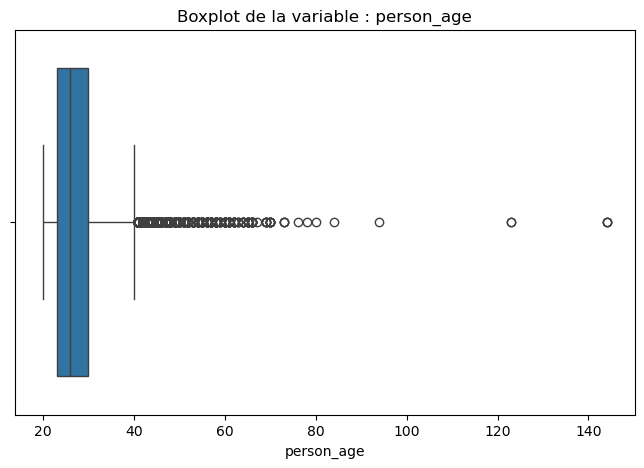

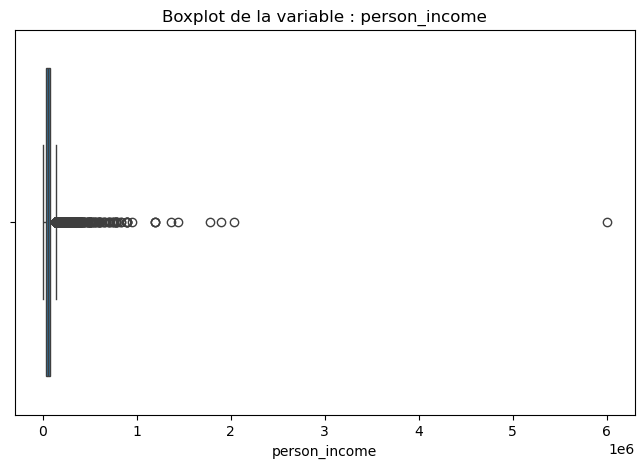

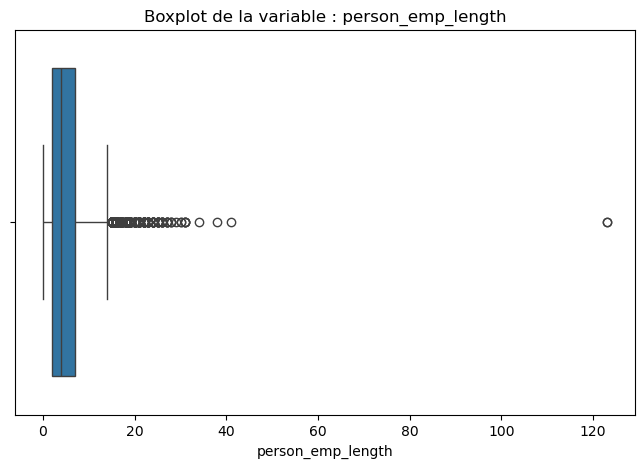

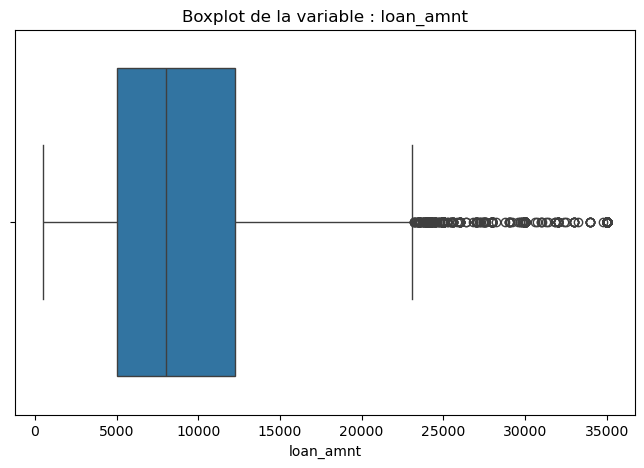

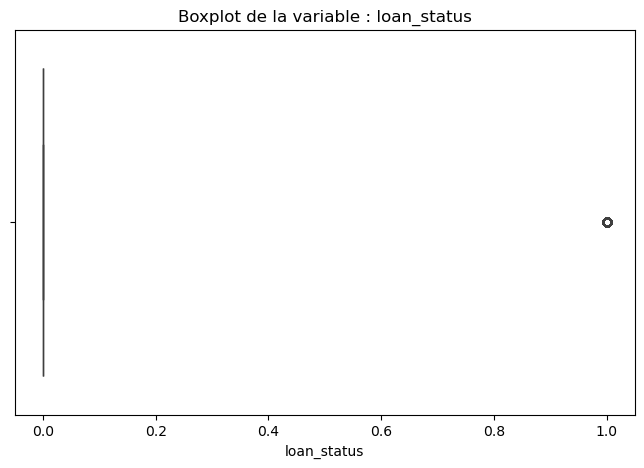

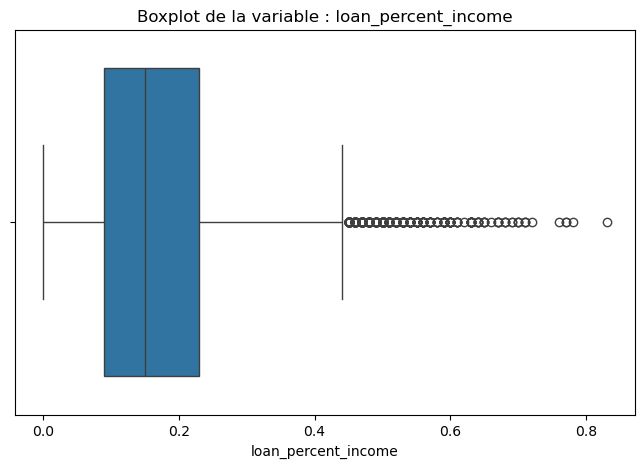

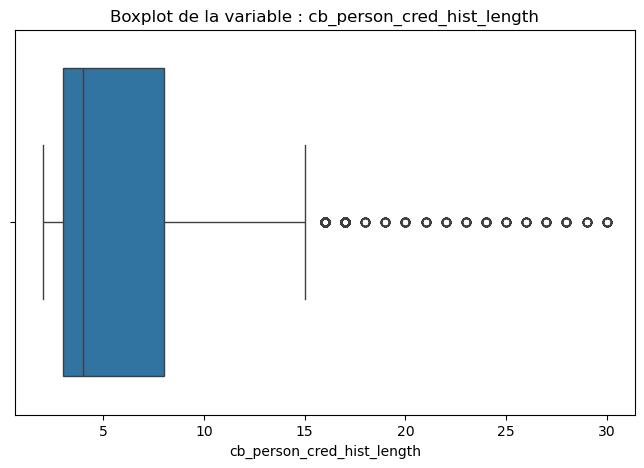

In [19]:
for col in col_num :
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=credit[col])
    plt.title(f'Boxplot de la variable : {col}')
    plt.xlabel(col)
    plt.show()

Les boîtes à moustaches nous signalent des valeurs aberrantes qui sont très probablement des erreurs de saisie :  

- **person_age** : Certains individus ont plus de 100 ans. Nous supprimerons ces lignes.  
- **person_emp_length** : Une ancienneté supérieure à 100 ans est impossible. Nous traiterons également ces cas.  
- **person_income** : Nous observons des revenus annuels très élevés (plus d'un million de dollars). Contrairement à l'âge, ces valeurs pourraient être légitimes.  
  Les supprimer pourrait biaiser notre analyse. Nous allons donc les conserver pour l'instant, mais nous garderons à l'esprit qu'une transformation logarithmique pourrait être bénéfique pour stabiliser la variance et réduire l'influence de ces outliers sur la régression logistique.

In [20]:
(credit['person_age'] > 100).sum()

5

In [21]:
credit = credit[credit['person_age'] <= 100]

In [22]:
(credit['person_emp_length'] > 100).sum()

2

In [23]:
credit = credit[credit['person_emp_length'] <= 100]

In [24]:
credit.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,1000,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,35000,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,35000,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,2500,1,0.25,N,2


<h2 style="color:#8c2f2f;">
    II- Analyse exploratoire des données
</h2>

<h3 style="color:#9e3b3b;">
    A. Analyse de la variable cible 
</h3>

In [25]:
X = credit.drop(columns='loan_status')
y = credit['loan_status']

In [26]:
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,1000,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,35000,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,35000,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,2500,0.25,N,2


In [27]:
y.head()

1    0
2    1
3    1
4    1
5    1
Name: loan_status, dtype: int64

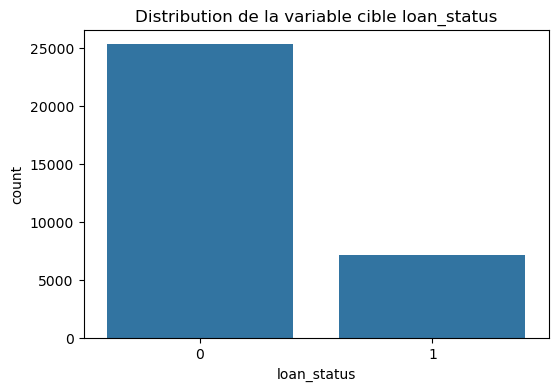

In [28]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Distribution de la variable cible loan_status")
plt.show()

Nous avons des données déséquilibrées. Le nombre de clients qui font défaut (`loan_status` = 1) est bien plus faible que le nombre de ceux qui ne font pas défaut (`loan_status` = 0). Si nous ne prenons pas en compte ce déséquilibre, notre modèle risquerait de toujours prédire le non-défaut du client, ce qui serait embêtant pour un établissement bancaire. Pour éviter cela, nous pouvons essayer de rééchantilloner les données.

<h3 style="color:#9e3b3b;">
    B. Relations entre les variables explicatives qualitatives et la variable dépendante  
</h3>

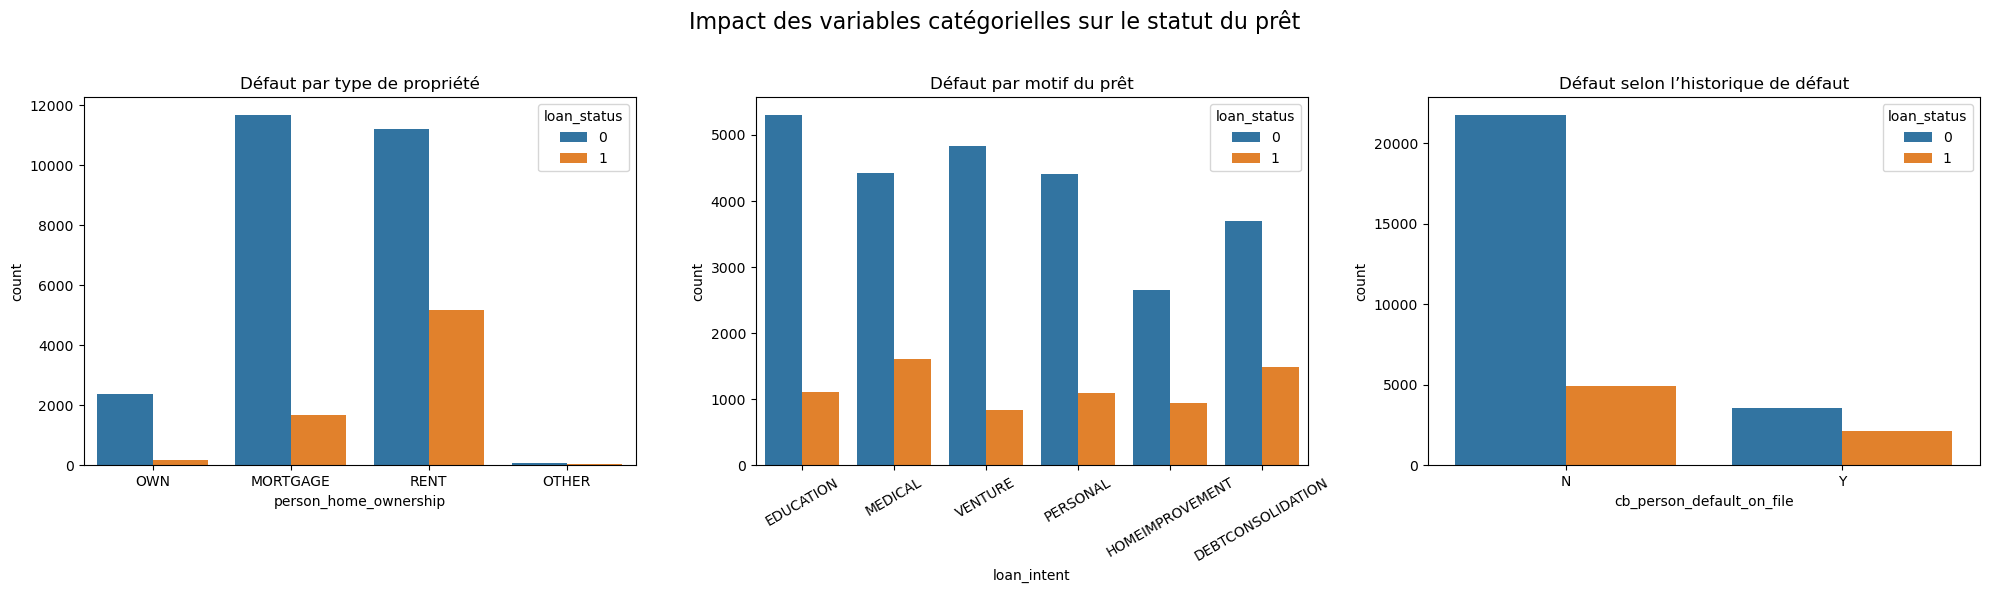

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Impact des variables catégorielles sur le statut du prêt", fontsize=16)

# Type de propriété
sns.countplot(ax=axes[0], data=credit, x="person_home_ownership", hue="loan_status")
axes[0].set_title("Défaut par type de propriété")

# Motif du prêt
sns.countplot(ax=axes[1], data=credit, x="loan_intent", hue="loan_status")
axes[1].tick_params(axis="x", rotation=30)
axes[1].set_title("Défaut par motif du prêt")

# Historique de défaut
sns.countplot(ax=axes[2], data=credit, x="cb_person_default_on_file", hue="loan_status")
axes[2].set_title("Défaut selon l’historique de défaut")  

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Nous observons clairement que les personnes ayant déjà eu un défaut par le passé (`cb_person_default_on_file` = Y) ont un taux de défaut bien plus élevé que celles qui n'en ont jamais eu.

<h3 style="color:#9e3b3b;">
    C. Relations entre les variables explicatives numériques et la variable dépendante
</h3>

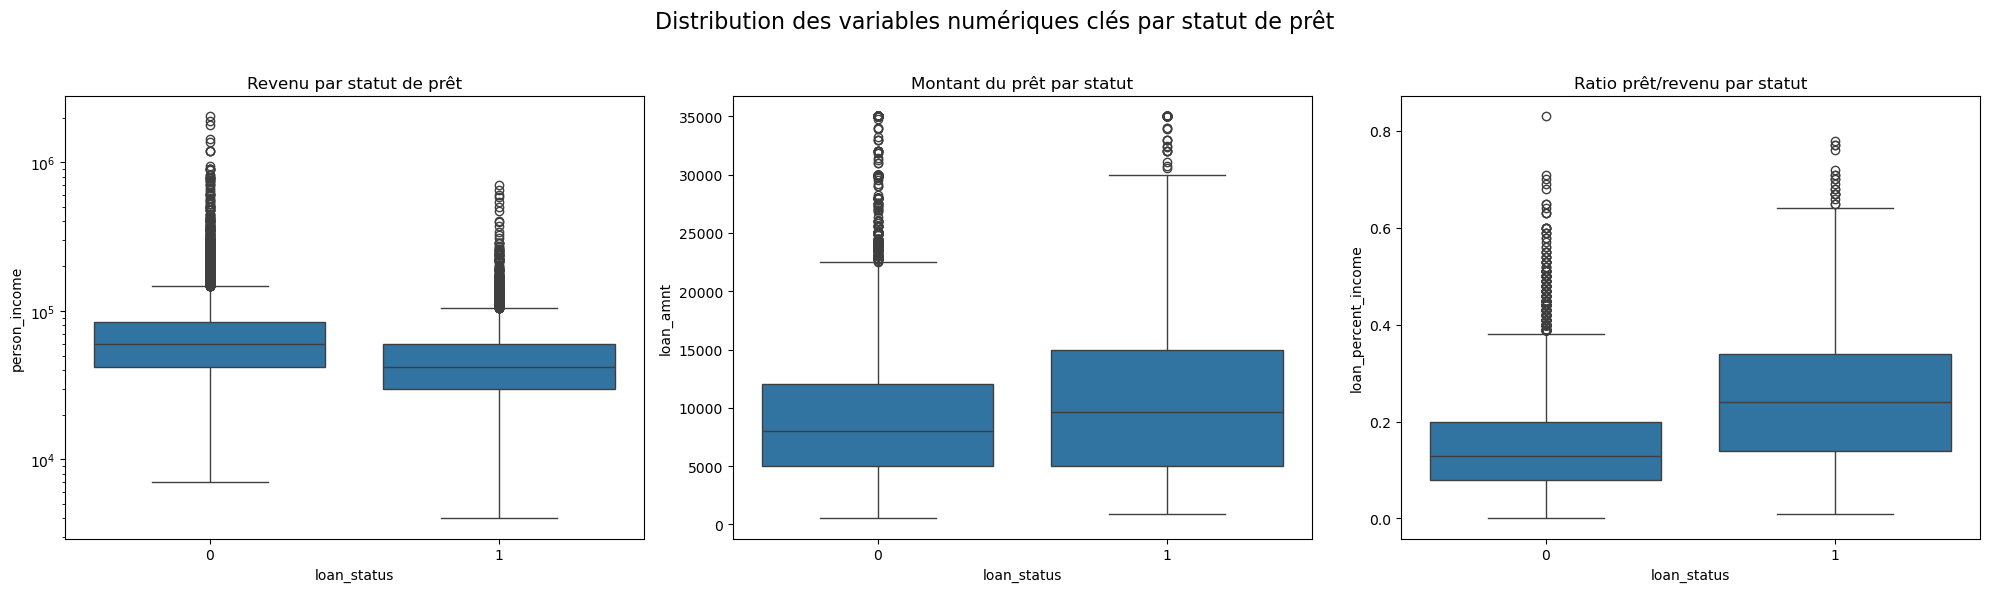

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Distribution des variables numériques clés par statut de prêt", fontsize=16)

sns.boxplot(ax=axes[0], data=credit, x='loan_status', y='person_income')
axes[0].set_title("Revenu par statut de prêt")
axes[0].set_yscale('log') # Echelle log pour mieux visualiser

sns.boxplot(ax=axes[1], data=credit, x='loan_status', y='loan_amnt')
axes[1].set_title("Montant du prêt par statut")

sns.boxplot(ax=axes[2], data=credit, x='loan_status', y='loan_percent_income')
axes[2].set_title("Ratio prêt/revenu par statut")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Nous pouvons observer que les clients en défaut de paiement ont en général un revenu plus faible que ceux qui remboursent leur prêt. De plus, les prêts non remboursés sont souvent d’un montant plus important que les prêts remboursés. Ainsi, les clients non solvables se distinguent par un ratio prêt/revenu plus élevé.

<h3 style="color:#9e3b3b;">
    D. Matrice de corrélation  
</h3>

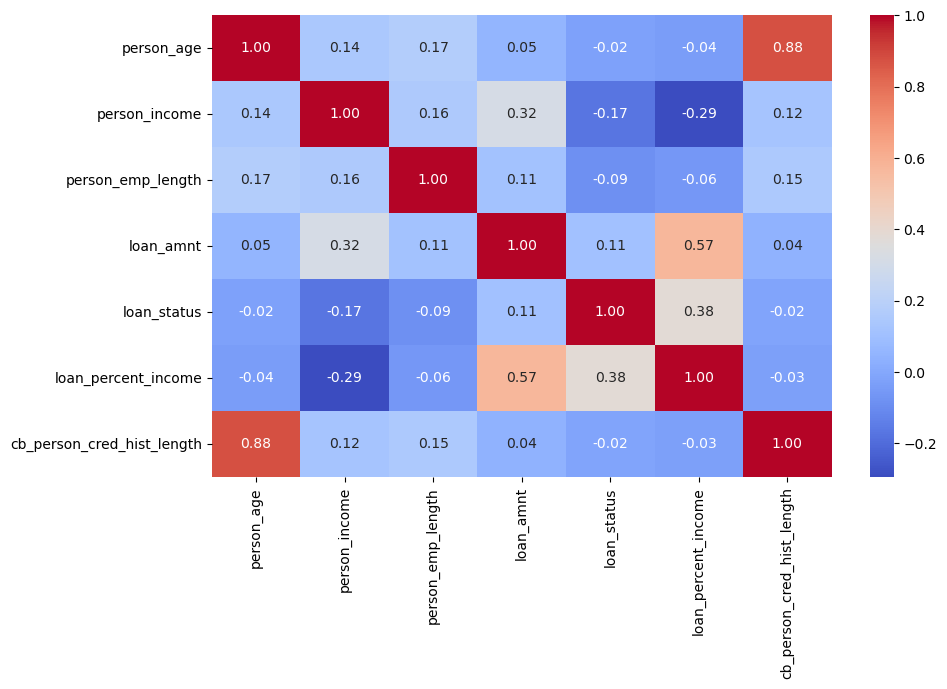

In [31]:
plt.figure(figsize=(10, 6))
sns.heatmap(credit.select_dtypes(include=['number']).corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Nous observons une forte corrélation positive (0.88) entre les variables `person_age` et `cb_person_cred_hist_length`. Nous allons uniquement garder `person_age` pour la suite afin d'éviter les problèmes de multicolinéarité et de réduire la redondance dans notre modèle.

In [32]:
X = X.drop(columns=["cb_person_cred_hist_length"])

In [33]:
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_percent_income,cb_person_default_on_file
1,21,9600,OWN,5.0,EDUCATION,1000,0.10,N
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,0.57,N
3,23,65500,RENT,4.0,MEDICAL,35000,0.53,N
4,24,54400,RENT,8.0,MEDICAL,35000,0.55,Y
5,21,9900,OWN,2.0,VENTURE,2500,0.25,N


<h2 style="color:#8c2f2f;">
    III- Modélisation et évaluation
</h2>

<h3 style="color:#9e3b3b;">
    A. Préparation des données pour le modèle
</h3>

<h4 style="color:#b55e5e;">
    1. Encodage des variables qualitatives et normalisation des variables numériques
</h4>

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32409 entries, 1 to 32580
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_age                 32409 non-null  int64  
 1   person_income              32409 non-null  int64  
 2   person_home_ownership      32409 non-null  object 
 3   person_emp_length          32409 non-null  float64
 4   loan_intent                32409 non-null  object 
 5   loan_amnt                  32409 non-null  int64  
 6   loan_percent_income        32409 non-null  float64
 7   cb_person_default_on_file  32409 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 2.2+ MB


In [35]:
var_nominal = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
var_num = ['person_age','person_income','person_emp_length','loan_amnt','loan_percent_income']

In [36]:
numeric_pipeline = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p)), # Transformation logarithmique des variables numériques 
    ('scaler', StandardScaler())
])

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, var_num), 
        ('nom', OneHotEncoder(drop='first', sparse_output=False), var_nominal)
    ],
    remainder='passthrough'
)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE) 

In [39]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [40]:
new_nominal_cols = preprocessor.named_transformers_['nom'].get_feature_names_out(var_nominal)
processed_cols = var_num + list(new_nominal_cols) 
X_train = pd.DataFrame(X_train_processed, columns=processed_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_processed, columns=processed_cols, index=X_test.index)

In [41]:
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_percent_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
30592,3.109559,0.132521,0.913270,-1.885069,-1.405154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16487,-0.422926,-0.376576,-1.902674,-0.597942,-0.554351,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
26956,0.827107,1.359158,0.762321,1.835104,0.705357,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
31677,1.426981,1.359158,0.393630,1.663374,0.426792,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9596,-1.065753,0.039264,0.591188,0.375910,0.141232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


<h4 style="color:#b55e5e;">
    3. Rééchantillonnage
</h4>

Nous allons comparer 3 méthodes de rééchantillonnage que sont le sous-échantillonnage, le suréchantillonnage et SMOTE.

In [42]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)  
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

os = RandomOverSampler(random_state=RANDOM_STATE)
X_train_os, y_train_os = os.fit_resample(X_train, y_train)

smote = SMOTE(sampling_strategy = 'minority',random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### - Evaluation d'un modèle de régression logistique entrainé sur l'ensemble d'entrainement brut

In [43]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

auc = roc_auc_score(y_test,y_pred)
print("AUC: %.2f%%" % (auc * 100.0))

Accuracy: 84.46%
AUC: 68.86%


#### - Evaluation d'un modèle de régression logistique entrainé sur l'ensemble d'entrainement après sous-échantillonnage

In [44]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_rus, y_train_rus)
y_pred_rus = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rus)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

auc = roc_auc_score(y_test,y_pred_rus)
print("AUC: %.2f%%" % (auc * 100.0))

Accuracy: 75.22%
AUC: 73.55%


#### - Evaluation d'un modèle de régression logistique entrainé sur l'ensemble d'entrainement après suréchantillonnage

In [45]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_os, y_train_os)
y_pred_os = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_os)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

auc = roc_auc_score(y_test,y_pred_os)
print("AUC: %.2f%%" % (auc * 100.0))

Accuracy: 75.39%
AUC: 73.63%


#### - Evaluation d'un modèle de régression logistique entrainé sur l'ensemble d'entrainement après SMOTE

In [46]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_smote)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

auc = roc_auc_score(y_test,y_pred_smote)
print("AUC: %.2f%%" % (auc * 100.0))

Accuracy: 75.10%
AUC: 73.50%


Bien que le modèle sans rééchantillonnage ait la meilleure accuracy (84.46%), cette métrique est trompeuse sur des données déséquilibrées.
Le score AUC, plus fiable, est nettement supérieur pour les trois méthodes de rééchantillonnage (plus de 0.73 contre 0.69), prouvant qu'elles permettent au modèle de beaucoup mieux distinguer les clients à risque des clients fiables ("moins de hasard"). Pour la suite nous allons choisir SMOTE, car malgré des performances similaires aux autres, il est théoriquement plus robuste en créant des exemples synthétiques plutôt qu'en dupliquant ou supprimant des données. Dorénavant, les modèles seront donc entrainés sur l'ensemble X_train_smote. 

<h3 style="color:#9e3b3b;">
    B. Entrainement et optimisation des modèles 
</h3>

Pour chaque modèle de classification, nous allons utiliser Grid Search avec validation croisée pour trouver automatiquement la meilleure configuration possible qui maximise la performance (mesurée par l'AUC ROC). De cette façon, nous obtiendrons le modèle le plus apte à distinguer un client à risque d'un client fiable, ce qui est exactement l'objectif de notre projet.

<h4 style="color:#b55e5e;">
    1. Regression logistique
</h4>

In [47]:
grid_searches = {}

param_grid_lr = [
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]},
    {'solver': ['lbfgs', 'newton-cg'], 'penalty': ['l2'], 'C': [0.1, 1, 10]},
    {'solver': ['saga'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]},
    {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': [0.1, 1, 10], 'l1_ratio': [0.25, 0.5, 0.75]}
]

grid_lr = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE, max_iter=2000), 
                       param_grid_lr, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_lr.fit(X_train_smote, y_train_smote) 
grid_searches['Logistic Regression'] = grid_lr
print(f"Meilleurs paramètres : {grid_lr.best_params_}")
print(f"Meilleur score ROC AUC après validation croisée: {grid_lr.best_score_:.4f}\n")

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Meilleurs paramètres : {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Meilleur score ROC AUC après validation croisée: 0.8205



<h4 style="color:#b55e5e;">
    2. Forêt aléatoire
</h4>

In [380]:
param_grid_rf = {
    'n_estimators': [150, 250],  
    'max_depth': [10, 20, 30],   
    'min_samples_leaf': [2, 4],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt', 0.5] 
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                       param_grid_rf, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train_smote, y_train_smote)
grid_searches['Random Forest'] = grid_rf
print(f"Meilleurs paramètres : {grid_rf.best_params_}")
print(f"Meilleur score ROC AUC après validation croisée : {grid_rf.best_score_:.4f}")

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Meilleurs paramètres : {'max_depth': 30, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 250}
Meilleur score ROC AUC après validation croisée : 0.9702


<h4 style="color:#b55e5e;">
    3. XGBoost
</h4>

In [381]:
param_grid_xgb = {
    'n_estimators': [150, 250],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],           
    'colsample_bytree': [0.7, 0.8],  
    'gamma': [0, 0.1],                
    'reg_lambda': [1, 2]               
}

grid_xgb = GridSearchCV(xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
                        param_grid_xgb, cv=10, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train_smote, y_train_smote)
grid_searches['XGBoost'] = grid_xgb
print(f"Meilleurs paramètres : {grid_xgb.best_params_}")
print(f"Meilleur score ROC AUC après validation croisée : {grid_xgb.best_score_:.4f}")

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Meilleurs paramètres : {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 250, 'reg_lambda': 1, 'subsample': 0.8}
Meilleur score ROC AUC après validation croisée : 0.9741


<h3 style="color:#9e3b3b;">
    C. Evaluation finale des modèles 
</h3>


*Évaluation du modèle : Logistic Regression*
Accuracy : 0.7496
Score ROC AUC : 0.8161
Rapport de classification :
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      5093
           1       0.45      0.71      0.55      1389

    accuracy                           0.75      6482
   macro avg       0.68      0.73      0.69      6482
weighted avg       0.81      0.75      0.77      6482


*Évaluation du modèle : Random Forest*
Accuracy : 0.8778
Score ROC AUC : 0.8802
Rapport de classification :
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      5093
           1       0.77      0.62      0.68      1389

    accuracy                           0.88      6482
   macro avg       0.83      0.78      0.80      6482
weighted avg       0.87      0.88      0.87      6482


*Évaluation du modèle : XGBoost*
Accuracy : 0.8923
Score ROC AUC : 0.8959
Rapport de classification :
              preci

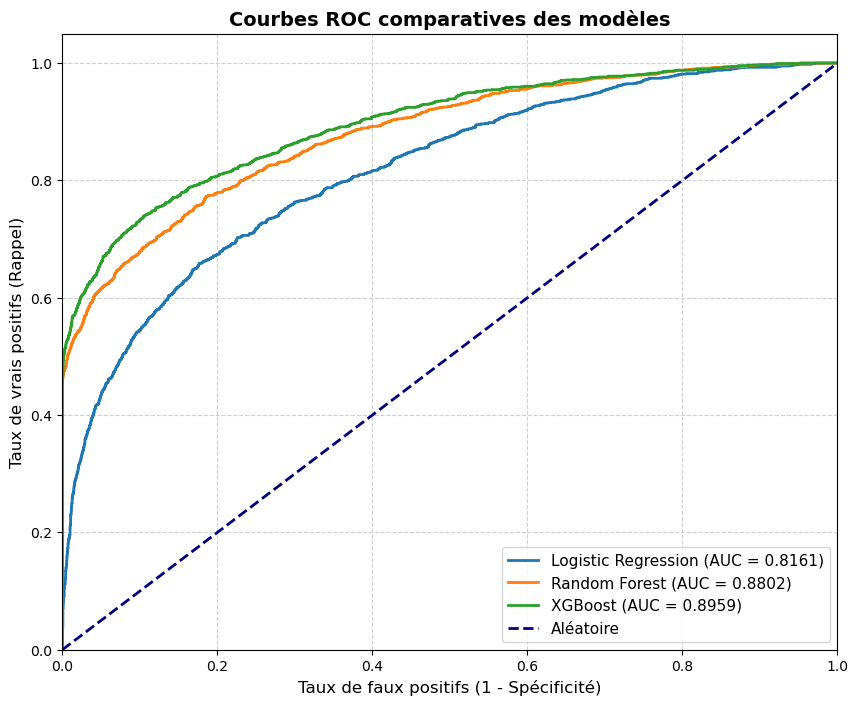

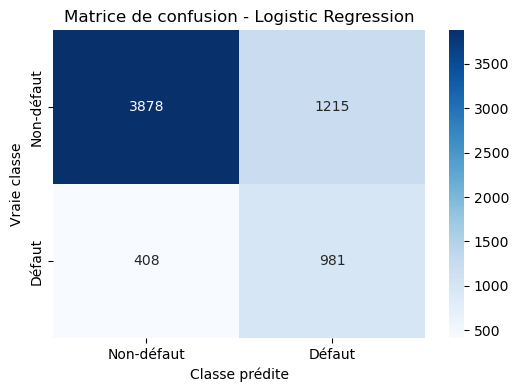

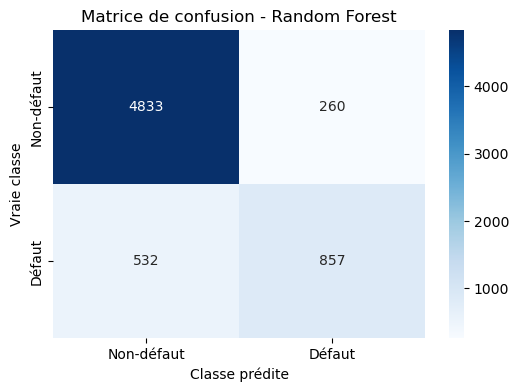

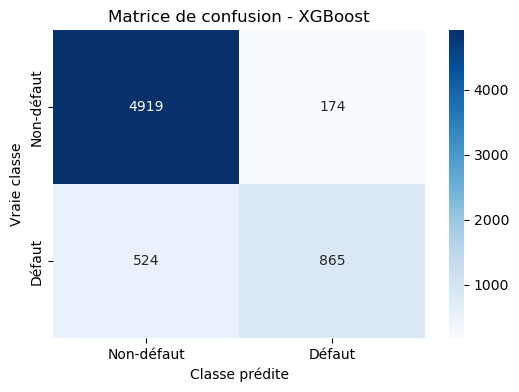

In [382]:
results = {}

fig_roc, ax_roc = plt.subplots(figsize=(10, 8))

for name, grid_search_object in grid_searches.items():
    print(f"\n*Évaluation du modèle : {name}*")

    best_model = grid_search_object.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'Accuracy': acc, 'ROC AUC': auc,
        'F1-Score': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],
        'Meilleurs paramètres': grid_search_object.best_params_
    }
    
    print(f"Accuracy : {acc:.4f}")
    print(f"Score ROC AUC : {auc:.4f}")
    print("Rapport de classification :")
    print(report)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-défaut', 'Défaut'],
                yticklabels=['Non-défaut', 'Défaut'])
    plt.title(f'Matrice de confusion - {name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax_roc.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('Taux de faux positifs (1 - Spécificité)', fontsize=12)
ax_roc.set_ylabel('Taux de vrais positifs (Rappel)', fontsize=12)
ax_roc.set_title('Courbes ROC comparatives des modèles', fontsize=14, fontweight='bold')
ax_roc.legend(loc="lower right", fontsize=11)
ax_roc.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [383]:
results_df = pd.DataFrame(results).T.sort_values(by='ROC AUC', ascending=False)
results_df = results_df[['Accuracy', 'ROC AUC', 'F1-Score', 'Meilleurs paramètres']]
print("\nTableau comparatif des performances :")
print(results_df)


Tableau comparatif des performances :
                     Accuracy   ROC AUC  F1-Score  \
XGBoost              0.892317  0.895884  0.712521   
Random Forest        0.877815  0.880215  0.683958   
Logistic Regression  0.749614  0.816052   0.54728   

                                                  Meilleurs paramètres  
XGBoost              {'colsample_bytree': 0.8, 'gamma': 0.1, 'learn...  
Random Forest        {'max_depth': 30, 'max_features': 0.5, 'min_sa...  
Logistic Regression     {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}  


Après comparaison des performances sur l'ensemble de test, le modèle XGBoost se distingue comme le plus performant. Son AUC de 0.896 signifie qu'il a une excellente capacité à distinguer un bon client d'un client à risque. Son F1-score de 0.71 sur la classe 'défaut' indique un excellent compromis : il parvient à identifier 62% des vrais défauts (recall) tout en s'assurant que 83% de ses alertes de défaut sont correctes (precision). Pour un établissement de crédit, cela se traduit par une réduction significative des pertes liées aux mauvais crédits, tout en minimisant le nombre de bons clients refusés à tort.

 <h3 style="color:#9e3b3b;">
    D. Interprétabilité du modèle : importance des variables 
</h3> 

Le modèle XGBoost étant le plus performant, nous allons maintenant analyser quelles variables ont le plus d'impact sur sa décision de prédire un défaut de paiement.

Top 10 des variables les plus importantes :
                       feature  importance
0    person_home_ownership_OWN    0.263316
1   person_home_ownership_RENT    0.131909
2  cb_person_default_on_file_Y    0.104510
3          loan_intent_VENTURE    0.078539
4          loan_percent_income    0.073769
5  loan_intent_HOMEIMPROVEMENT    0.061533
6                   person_age    0.045669
7        loan_intent_EDUCATION    0.045666
8                person_income    0.041404
9         loan_intent_PERSONAL    0.038476




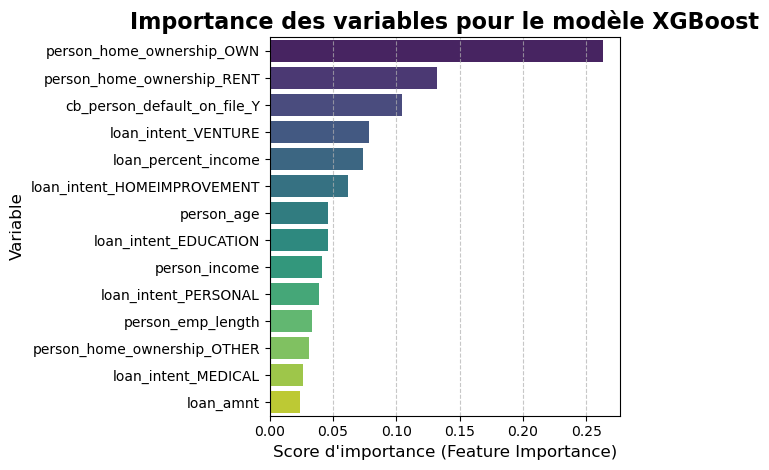

In [388]:
best_xgb_model = grid_searches['XGBoost'].best_estimator_

numeric_features = var_num  

onehot_features = list(preprocessor.named_transformers_['nom'].get_feature_names_out(var_nominal))

all_feature_names = numeric_features + onehot_features

feature_importances_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': best_xgb_model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 10 des variables les plus importantes :")
print(feature_importances_df.head(10))
print("\n")

sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importances_df, 
    hue='feature', 
    palette='viridis',
    legend=False # 
)
plt.title('Importance des variables pour le modèle XGBoost', fontsize=16, fontweight='bold')
plt.xlabel('Score d\'importance', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

L'analyse des variables les plus importantes pour le modèle **XGBoost** révèle une hiérarchie de décision très logique :
- **Statut immobilier (`person_home_ownership`)** :  
  Il s'agit du facteur le plus discriminant. Le fait d'être propriétaire (`OWN`) ou locataire (`RENT`) constitue le premier indicateur de la stabilité financière du demandeur, avec une importance cumulée de près de 40 %.
- **Historique de défaut (`cb_person_default_on_file`)** :  
  Ce critère est le deuxième facteur clé. Comme attendu, un défaut de paiement passé est un puissant prédicteur d'un risque futur, ce qui en fait la troisième variable la plus influente.
- **Nature du prêt et capacité de remboursement** :  
  Le modèle accorde une grande importance au motif du prêt (notamment les prêts `VENTURE`, considérés comme plus risqués) et au ratio prêt/revenu (`loan_percent_income`), qui mesure directement la pression financière sur l'emprunteur.
- **Caractéristiques socio-démographiques** :  
  Des variables telles que l'âge (`person_age`) et le revenu (`person_income`), bien que moins prédictives que les facteurs précédents, contribuent néanmoins à affiner l'évaluation du risque.

<h2 style="color:#8c2f2f;">
    Conclusion
</h2>

Au terme de ce projet, nous avons réussi à développer un modèle de scoring de crédit performant en suivant une méthodologie rigoureuse, de la préparation des données à l'évaluation finale.  
L'analyse a démontré que des étapes de prétraitement critiques, comme la suppression des variables causant une fuite de données (`loan_grade`) et le rééchantillonnage des classes déséquilibrées avec SMOTE, étaient essentielles pour construire un modèle à la fois réaliste et efficace.  
La comparaison de plusieurs algorithmes a clairement désigné le modèle XGBoost comme étant le plus performant. Après optimisation, il a atteint un excellent score AUC ROC de 0.896 et une accuracy de 89.2% sur l'ensemble de test. Ces métriques indiquent une très grande capacité du modèle à distinguer les clients fiables des clients à risque, ce qui est l'objectif principal du scoring de crédit.  
De plus, l'analyse de l'importance des variables a montré que le modèle base ses prédictions sur des critères logiques et pertinents d'un point de vue métier, tels que le statut immobilier, l'historique de défaut et le ratio prêt/revenu.  
En conclusion, ce projet a permis de construire une solution de machine learning robuste et interprétable, fournissant un outil d'aide à la décision fiable et automatisé pour l'évaluation du risque de crédit. Le modèle final, sauvegardé, constitue une base solide pour un déploiement en production, par exemple via une interface applicative simple.  